<a href="https://colab.research.google.com/github/GabrielaR-14/data_challenge/blob/main/Clasificaci%C3%B3n_Vendedores.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Score vendedores Mercado Libre
**Objetivo:** 

Identificar a los mejores vendedores de Mercado Libre (Argentina) para generar estrategias focalizadas que permitan incrementar la rentabilidad del negocio.


Para poder abordar el problema de manera correcta, es necesario preguntarse 
¿Qué características tiene un buen vendedor para el negocio? 

Inicialmente, la rentabilidad que le deja, la cual está relacionada con el monto facturado, el cual depende del precio y la cantidad de los productos. 

Para efectos del modelo, vamos a considerar que un buen vendedor tiene:
1. Alta facturación
2. Tasa de cancelaciones y reclamaciones baja
3. Un buen Net Promoter Score (NPS) [Rating positivo - Rating Negativo]
4. Un buen potencial definido por: Una alta rotación de inventario y ventas esperadas futuras.

Cabe destacar que las variables que se van a incluir dentro del modelo, dependerán del análisis de los datos en las diferentes de la exploración.

#### Importación de Librerías

In [ ]:
#Tratamiento de datos
import pandas as pd
import numpy as np
import string
import io
import json
from pandas import json_normalize
from pandas.io.json import json_normalize
import requests
from datetime import timedelta
import datetime as dt


#Gráficos
import seaborn as sns
import matplotlib.pyplot as plt

#Preprocesado y modelado
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import statsmodels.formula.api as sm
from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#### Extracción de los datos

In [ ]:
#Revisión de las categorías
cats = requests.get('https://api.mercadolibre.com/sites/MLA/categories')
cats = cats.json()
#cats

Inicialmente, se planeó la posibilidad de generar un modelo por categoría ya que las estrategias comerciales pueden variar a través de las mismas, no obstante, teniendo en cuenta que hay 32 categorías en total, se decidió concatenar toda la información y dejar un modelo general.

In [ ]:
#Extracción de datasets
from tqdm import tqdm
appended_data = []

for i in tqdm(range(len(cats))):    
    cat_id = cats[i]['id'] #Cambiar de acuerdo a la categoría que se quiera revisar
    cat_name = cats[i]['name']
    #Extracción de datasets
    offset = list(range(0,1000,50))    
    for entry in offset:
        offset = entry
        url = f'https://api.mercadolibre.com/sites/MLA/search?category={cat_id}&offset={offset}'
        urlData = requests.get(url).content
        dict = json.loads(urlData)
        data = json_normalize(dict['results'])
        data['categories'] = cat_name
        appended_data.append(data)

appended_data = pd.concat(appended_data)

  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  from ipykernel import kernelapp as app
100%|██████████| 32/32 [11:44<00:00, 22.01s/it]


### EDA

In [434]:
#Información de las variables disponibles
pd.set_option('display.max_columns', None)
appended_data.describe()

,price,available_quantity,sold_quantity,order_backend,seller.id,seller.seller_reputation.metrics.cancellations.rate,seller.seller_reputation.metrics.cancellations.value,seller.seller_reputation.metrics.claims.rate,seller.seller_reputation.metrics.claims.value,seller.seller_reputation.metrics.delayed_handling_time.rate,seller.seller_reputation.metrics.delayed_handling_time.value,seller.seller_reputation.metrics.sales.completed,seller.seller_reputation.transactions.canceled,seller.seller_reputation.transactions.total,seller.seller_reputation.transactions.ratings.negative,seller.seller_reputation.transactions.ratings.neutral,seller.seller_reputation.transactions.ratings.positive,seller.seller_reputation.transactions.completed,installments.quantity,installments.amount,installments.rate,seller.eshop.seller,seller.eshop.eshop_rubro,seller.eshop.eshop_id,seller.eshop.eshop_status_id,seller.eshop.eshop_experience,seller.seller_reputation.metrics.cancellations.excluded.real_value,seller.seller_reputation.metrics.cancellations.excluded.real_rate,seller.seller_reputation.metrics.claims.excluded.real_value,seller.seller_reputation.metrics.claims.excluded.real_rate,seller.seller_reputation.metrics.delayed_handling_time.excluded.real_value,seller.seller_reputation.metrics.delayed_handling_time.excluded.real_rate,differential_pricing.id,location.latitude,location.longitude
count,3.158300e+04,31892.000000,31892.000000,31892.000000,3.189200e+04,31892.000000,31892.000000,31892.000000,31892.000000,31892.000000,31892.000000,31892.000000,31892.000000,3.189200e+04,31892.000000,31892.000000,31892.000000,3.189200e+04,29582.000000,29582.000000,29582.000000,1.740300e+04,0.0,17403.000000,17403.000000,17403.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,2.642000e+03,2993.000000,2993.000000
mean,1.670696e+05,481.774614,421.099962,25.499373,2.254803e+08,0.002884,33.998087,0.005791,85.611689,0.020564,169.392481,10609.768970,3159.164305,6.234458e+04,0.019391,0.024162,0.920889,5.918542e+04,11.596782,1949.573564,63.903042,1.694405e+08,NaN,254900.446187,1.197150,116.253175,16.000000,0.010819,40.324324,0.013171,154.563964,0.097586,3.469342e+07,-34.752630,-58.771568
std,9.681382e+05,3827.961518,1724.554799,14.430581,2.076797e+08,0.015963,98.395791,0.006152,243.477111,0.029032,469.180170,24579.920596,7892.360656,1.464256e+05,0.026137,0.093380,0.201354,1.386926e+05,1.522583,4832.087221,20.012276,1.536504e+08,NaN,138095.849963,0.397858,468.374945,47.612189,0.026015,111.883043,0.015081,361.347120,0.075737,1.017737e+06,1.377271,1.707207
min,1.000000e+00,1.000000,0.000000,1.000000,9.590000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,3.000000,0.140000,0.000000,1.044300e+05,NaN,303.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.367819e+07,-41.184925,-71.509060
25%,1.598500e+03,1.000000,11.000000,13.000000,7.677487e+07,0.000000,0.000000,0.000000,2.000000,0.001400,2.000000,548.000000,130.000000,3.001750e+03,0.000000,0.010000,0.950000,2.864000e+03,12.000000,212.570000,70.170000,5.773048e+07,NaN,146031.500000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,7.000000,0.029850,3.367819e+07,-34.659412,-58.616722
50%,4.600000e+03,5.000000,100.000000,25.000000,1.685806e+08,0.000600,4.000000,0.005000,14.000000,0.009100,20.000000,2341.000000,685.000000,1.484900e+04,0.010000,0.010000,0.970000,1.391100e+04,12.000000,567.090000,70.170000,1.396735e+08,NaN,256712.000000,1.000000,0.000000,4.000000,0.004500,4.000000,0.014100,20.000000,0.089000,3.367819e+07,-34.605800,-58.469604
75%,1.490515e+04,100.000000,500.000000,38.000000,2.967286e+08,0.003900,20.000000,0.009500,58.000000,0.027700,118.000000,8360.000000,2378.000000,5.093800e+04,0.030000,0.020000,0.980000,4.798600e+04,12.000000,1499.672500,70.170000,2.167926e+08,NaN,369045.500000,1.000000,0.000000,12.000000,0.012500,24.500000,0.021300,97.000000,0.161500,3.571328e+07,-34.553680,-58.400528


In [435]:
#Selección preliminar de las variables que se van a considerar dentro del modelo
df = appended_data[["id", "title", "price", "available_quantity", "sold_quantity","seller.registration_date", "seller.id", "seller.seller_reputation.power_seller_status", "seller.seller_reputation.metrics.cancellations.rate", 
          "seller.seller_reputation.metrics.cancellations.value","seller.seller_reputation.metrics.claims.rate", "seller.seller_reputation.metrics.claims.value", "seller.seller_reputation.metrics.delayed_handling_time.rate", 
          "seller.seller_reputation.metrics.sales.completed", "seller.seller_reputation.metrics.sales.period", "seller.seller_reputation.transactions.canceled", "seller.seller_reputation.transactions.total", "seller.seller_reputation.transactions.completed", 
          "seller.seller_reputation.transactions.ratings.negative", "seller.seller_reputation.transactions.ratings.neutral", "seller.seller_reputation.transactions.ratings.positive", "categories"]]

In [436]:
df.rename(columns={'seller.seller_reputation.power_seller_status': 'seller_status', 'seller.registration_date': 'reg_date', 'seller.seller_reputation.metrics.cancellations.rate': 'cancellation_rate',
                   'seller.seller_reputation.metrics.cancellations.value' : 'cancellations_value', 'seller.seller_reputation.metrics.claims.rate' : 'claims_rate',
                   'seller.seller_reputation.metrics.claims.value' : 'claims_value', 'seller.seller_reputation.metrics.delayed_handling_time.rate' : 'delayed_time_rate',
                   'seller.seller_reputation.metrics.sales.completed': 'sales_completed', 
                   'seller.seller_reputation.metrics.sales.period' : 'period','seller.seller_reputation.transactions.canceled': 'hist_trx_canceled',
                   'seller.seller_reputation.transactions.total' : 'hist_trx_total','seller.seller_reputation.transactions.completed': 'hist_trx_completed',
                   'seller.seller_reputation.transactions.ratings.negative' : 'rat_negative','seller.seller_reputation.transactions.ratings.neutral': 'rat_neutral',
                   'seller.seller_reputation.transactions.ratings.positive': 'rat_positive'}, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [437]:
pd.set_option('display.max_columns', None)
df.describe()

,price,available_quantity,sold_quantity,seller.id,cancellation_rate,cancellations_value,claims_rate,claims_value,delayed_time_rate,sales_completed,hist_trx_canceled,hist_trx_total,hist_trx_completed,rat_negative,rat_neutral,rat_positive
count,3.158300e+04,31892.000000,31892.000000,3.189200e+04,31892.000000,31892.000000,31892.000000,31892.000000,31892.000000,31892.000000,31892.000000,3.189200e+04,3.189200e+04,31892.000000,31892.000000,31892.000000
mean,1.670696e+05,481.774614,421.099962,2.254803e+08,0.002884,33.998087,0.005791,85.611689,0.020564,10609.768970,3159.164305,6.234458e+04,5.918542e+04,0.019391,0.024162,0.920889
std,9.681382e+05,3827.961518,1724.554799,2.076797e+08,0.015963,98.395791,0.006152,243.477111,0.029032,24579.920596,7892.360656,1.464256e+05,1.386926e+05,0.026137,0.093380,0.201354
min,1.000000e+00,1.000000,0.000000,9.590000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000
25%,1.598500e+03,1.000000,11.000000,7.677487e+07,0.000000,0.000000,0.000000,2.000000,0.001400,548.000000,130.000000,3.001750e+03,2.864000e+03,0.000000,0.010000,0.950000
50%,4.600000e+03,5.000000,100.000000,1.685806e+08,0.000600,4.000000,0.005000,14.000000,0.009100,2341.000000,685.000000,1.484900e+04,1.391100e+04,0.010000,0.010000,0.970000
75%,1.490515e+04,100.000000,500.000000,2.967286e+08,0.003900,20.000000,0.009500,58.000000,0.027700,8360.000000,2378.000000,5.093800e+04,4.798600e+04,0.030000,0.020000,0.980000
max,1.476000e+07,99999.000000,52402.000000,1.130056e+09,1.000000,903.000000,0.500000,1988.000000,0.464200,179857.000000,72736.000000,1.353141e+06,1.280405e+06,1.000000,1.000000,1.000000


#### Manejo de los valores nulos

In [438]:
#Establecer categoría para los clientes sin status
df['seller_status'] = df['seller_status'].fillna("No_Category")

#Asignar valor 0 a los items sin precio 
df['price'] = df['price'].fillna(0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [439]:
#Borrar valores nulos
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna()

#### Creación de variables adicionales

In [440]:
#Monto facturado por producto
df["sold_amount"] = df["price"]*df["sold_quantity"]

#Indicador NPS (Net Promoter Score)
df["nps"] = df["rat_positive"] - df["rat_negative"]

#Antiguedad del cliente (Meses)
date = df["reg_date"].str[:10]
df["date"] = pd.to_datetime(date, format = '%Y-%m-%d')

today = dt.datetime.now().strftime('%Y-%m-%d')
today = pd.to_datetime(today, format = '%Y-%m-%d')

df["ant_months"] = (today - df["date"]).dt.days
#df["ant_months"] = df["ant_months"].fillna(0)
df["ant_months"] = df["ant_months"].astype(int)/30

#Promedio de ventas mensuales (histórico)
df["avg_sales_month"] = df['hist_trx_completed'].divide(df['ant_months']).replace(np.inf, 0)

#Efectividad de venta vs stock
df["ef_sales_vs_stock"] = df["sold_quantity"] / (df["available_quantity"] + df["sold_quantity"])

#Ventas Potenciales en los próximos meses con historico
df["potential_selling_time"] = df['available_quantity'].divide(df['avg_sales_month']).replace(np.inf, 0) #Meses que le va a tomar al cliente vender su stock según su comportamiento
df["potential_sales"] = (df["potential_selling_time"] * df["available_quantity"] * df["price"]) * (1- df["cancellation_rate"]) #Potencial de ventas en dinero

#Creacion de Status numérico
df.loc[df['seller_status'] == 'platinum', 'status'] = 100
df.loc[df['seller_status'] == 'gold', 'status'] = 75
df.loc[df['seller_status']== 'silver', 'status'] = 50
df.loc[df['seller_status']== 'No_Category', 'status'] = 25

#Porcentaje de efectividad últimos dos meses vs histórico
#df["per_sales_60d_vs_hist"] = df["sales_completed"] / df["hist_trx_completed"]

In [441]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31892 entries, 0 to 49
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   id                      31892 non-null  object        
 1   title                   31892 non-null  object        
 2   price                   31892 non-null  float64       
 3   available_quantity      31892 non-null  int64         
 4   sold_quantity           31892 non-null  int64         
 5   reg_date                31892 non-null  object        
 6   seller.id               31892 non-null  int64         
 7   seller_status           31892 non-null  object        
 8   cancellation_rate       31892 non-null  float64       
 9   cancellations_value     31892 non-null  int64         
 10  claims_rate             31892 non-null  float64       
 11  claims_value            31892 non-null  int64         
 12  delayed_time_rate       31892 non-null  float64  

#### Variables finales

In [442]:
#Seleccionamos las variables que nos ayudarán en la construcción del modelo
df_final = df[["seller.id", "price","available_quantity","sold_quantity", "status", "cancellation_rate", "claims_rate", "delayed_time_rate", 
          "ant_months", "sold_amount", "nps", "potential_sales", "avg_sales_month", "hist_trx_completed", "hist_trx_canceled"
          ,"rat_neutral", "rat_positive", "rat_negative", "sales_completed", "categories"
         ]]

In [443]:
df_final.describe()

,seller.id,price,available_quantity,sold_quantity,status,cancellation_rate,claims_rate,delayed_time_rate,ant_months,sold_amount,nps,potential_sales,avg_sales_month,hist_trx_completed,hist_trx_canceled,rat_neutral,rat_positive,rat_negative,sales_completed
count,3.189200e+04,3.189200e+04,31892.000000,31892.000000,31892.000000,31892.000000,31892.000000,31892.000000,31892.000000,3.189200e+04,31892.000000,3.189200e+04,31892.000000,3.189200e+04,31892.000000,31892.000000,31892.000000,31892.000000,31892.000000
mean,2.254803e+08,1.654508e+05,481.774614,421.099962,87.090806,0.002884,0.005791,0.020564,103.732823,1.995731e+06,0.901498,1.850854e+09,980.983789,5.918542e+04,3159.164305,0.024162,0.920889,0.019391,10609.768970
std,2.076797e+08,9.635755e+05,3827.961518,1724.554799,26.151500,0.015963,0.006152,0.029032,64.434128,8.215012e+06,0.202873,1.184966e+11,4045.348392,1.386926e+05,7892.360656,0.093380,0.201354,0.026137,24579.920596
min,9.590000e+03,0.000000e+00,1.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.100000,0.000000e+00,-1.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.677487e+07,1.529500e+03,1.000000,11.000000,100.000000,0.000000,0.000000,0.001400,51.133333,6.579133e+04,0.920000,5.088066e+01,34.250253,2.864000e+03,130.000000,0.010000,0.950000,0.000000,548.000000
50%,1.685806e+08,4.500000e+03,5.000000,100.000000,100.000000,0.000600,0.005000,0.009100,91.033333,3.971250e+05,0.950000,3.233566e+03,166.303526,1.391100e+04,685.000000,0.010000,0.970000,0.010000,2341.000000
75%,2.967286e+08,1.459900e+04,100.000000,500.000000,100.000000,0.003900,0.009500,0.027700,148.966667,1.413642e+06,0.980000,1.730601e+05,638.234832,4.798600e+04,2378.000000,0.020000,0.980000,0.030000,8360.000000
max,1.130056e+09,1.476000e+07,99999.000000,52402.000000,100.000000,1.000000,0.500000,0.464200,277.500000,6.039058e+08,1.000000,1.349634e+13,55750.580552,1.280405e+06,72736.000000,1.000000,1.000000,1.000000,179857.000000


#### Agrupación de datos por vendedor

Para hacer una revisión integral del comportamiento del vendedor, se realizó la agrupación de los datos de sus transacciones en las diferentes categorías y productos, utilizando la media. En total tenemos 7224 vendedores en MeLi Argentina, lo que equivale a una relación de 4 categorías por vendedor.

In [444]:
#### Agrupación de los datos por vendedor y categoría
df_final_cat = df_final.groupby(["seller.id", "categories", "nps", "cancellation_rate", "claims_rate", "delayed_time_rate", "avg_sales_month", "hist_trx_completed", "sales_completed",	"hist_trx_canceled", 
                             "rat_neutral",	"rat_positive",	"rat_negative","status","ant_months"]).mean().reset_index().set_index(['seller.id', 'categories'])

## Agrupación de los dato por vendedor
df_final= df_final.groupby(["seller.id", "nps", "cancellation_rate", "claims_rate", "delayed_time_rate", "avg_sales_month", "hist_trx_completed", "sales_completed",	"hist_trx_canceled", 
                             "rat_neutral",	"rat_positive",	"rat_negative", "status",
                             "ant_months"]).mean().reset_index().set_index(['seller.id'])                           


In [445]:
df_final.describe()

,nps,cancellation_rate,claims_rate,delayed_time_rate,avg_sales_month,hist_trx_completed,sales_completed,hist_trx_canceled,rat_neutral,rat_positive,rat_negative,status,ant_months,price,available_quantity,sold_quantity,sold_amount,potential_sales
count,7224.000000,7224.000000,7224.000000,7224.000000,7224.000000,7.224000e+03,7224.000000,7224.000000,7224.000000,7224.000000,7224.000000,7224.000000,7224.000000,7.224000e+03,7224.000000,7224.000000,7.224000e+03,7.224000e+03
mean,0.899351,0.002510,0.004173,0.020197,190.792984,1.178828e+04,2089.700443,621.889812,0.030638,0.915461,0.016110,73.667636,100.302685,1.443998e+05,387.131187,339.095786,1.346688e+06,2.916854e+09
std,0.232795,0.025674,0.007978,0.032093,954.273510,3.552266e+04,6090.240862,2025.542765,0.131517,0.226468,0.038514,32.189154,65.497609,8.284168e+05,2978.120790,1257.178916,3.432460e+06,9.108900e+10
min,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000,0.100000,0.000000e+00,1.000000,0.000000,0.000000e+00,0.000000e+00
25%,0.930000,0.000000,0.000000,0.000000,3.161208,2.827500e+02,106.000000,13.000000,0.000000,0.950000,0.000000,25.000000,46.433333,1.599906e+03,1.000000,8.381803,3.233710e+04,1.963204e+02
50%,0.970000,0.000000,0.000000,0.006100,36.488824,2.754500e+03,534.500000,132.000000,0.010000,0.980000,0.010000,100.000000,86.100000,4.049550e+03,2.307895,103.000000,3.931259e+05,1.176526e+04
75%,0.990000,0.001800,0.007500,0.026400,142.401410,1.041225e+04,1862.250000,517.000000,0.020000,0.990000,0.020000,100.000000,149.166667,1.322007e+04,67.000000,350.000000,1.273010e+06,4.269640e+05
max,1.000000,1.000000,0.500000,0.464200,55750.580552,1.280405e+06,179857.000000,72736.000000,1.000000,1.000000,1.000000,100.000000,277.500000,1.190000e+07,50000.000000,50000.000000,7.500000e+07,5.710701e+12


Se reformularon las columnas de efectividad de ventas y ventas potenciales

In [446]:
#Efectividad de venta
df_final["ef_sales_vs_available"] = df_final["sold_quantity"] / (df_final["available_quantity"] + df_final["sold_quantity"])

#Ventas Potenciales
df_final["potential_selling_time"] =df_final['available_quantity'].divide(df_final["avg_sales_month"]).replace(np.inf, 0) #Meses que le va a tomar al cliente vender su stock - historico
df_final

,nps,cancellation_rate,claims_rate,delayed_time_rate,avg_sales_month,hist_trx_completed,sales_completed,hist_trx_canceled,rat_neutral,rat_positive,rat_negative,status,ant_months,price,available_quantity,sold_quantity,sold_amount,potential_sales,ef_sales_vs_available,potential_selling_time
seller.id,,,,,,,,,,,,,,,,,,,,
9590,1.00,0.0000,0.0,0.0000,2.345722,446,95,8,0.00,1.00,0.00,25.0,190.133333,230.000,1.0,150.000,34500.000,9.805082e+01,0.993377,0.426308
39092,0.97,0.0065,0.0,0.0105,21.810526,4144,732,179,0.01,0.98,0.01,100.0,190.000000,1189.625,1.0,10.125,33449.375,5.418908e+01,0.910112,0.045849
60438,0.98,0.0000,0.0,0.1280,2.103078,574,127,23,0.00,0.99,0.01,50.0,272.933333,2990.000,150.0,200.000,598000.000,3.198883e+07,0.571429,71.324042
83182,1.00,0.0000,0.0,0.0000,2.418507,460,58,0,0.00,1.00,0.00,50.0,190.200000,0.000,1.0,500.000,0.000,0.000000e+00,0.998004,0.413478
101217,0.97,0.0000,0.0,0.0000,4.983784,1383,190,77,0.01,0.98,0.01,75.0,277.500000,38900.000,1.0,25.000,972500.000,7.805315e+03,0.961538,0.200651
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1125604025,1.00,0.0000,0.0,0.0000,5.625000,3,3,1,0.00,1.00,0.00,25.0,0.533333,11499.000,1.0,2.500,32497.500,2.044267e+03,0.714286,0.177778
1129675466,0.00,0.0000,0.0,0.0000,0.000000,0,0,0,0.00,0.00,0.00,25.0,0.300000,89000.000,1.0,0.000,0.000,0.000000e+00,0.000000,0.000000
1129786918,0.00,0.0000,0.0,0.0000,0.000000,0,0,0,0.00,0.00,0.00,25.0,0.300000,14000.000,1.0,0.000,0.000,0.000000e+00,0.000000,0.000000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  """


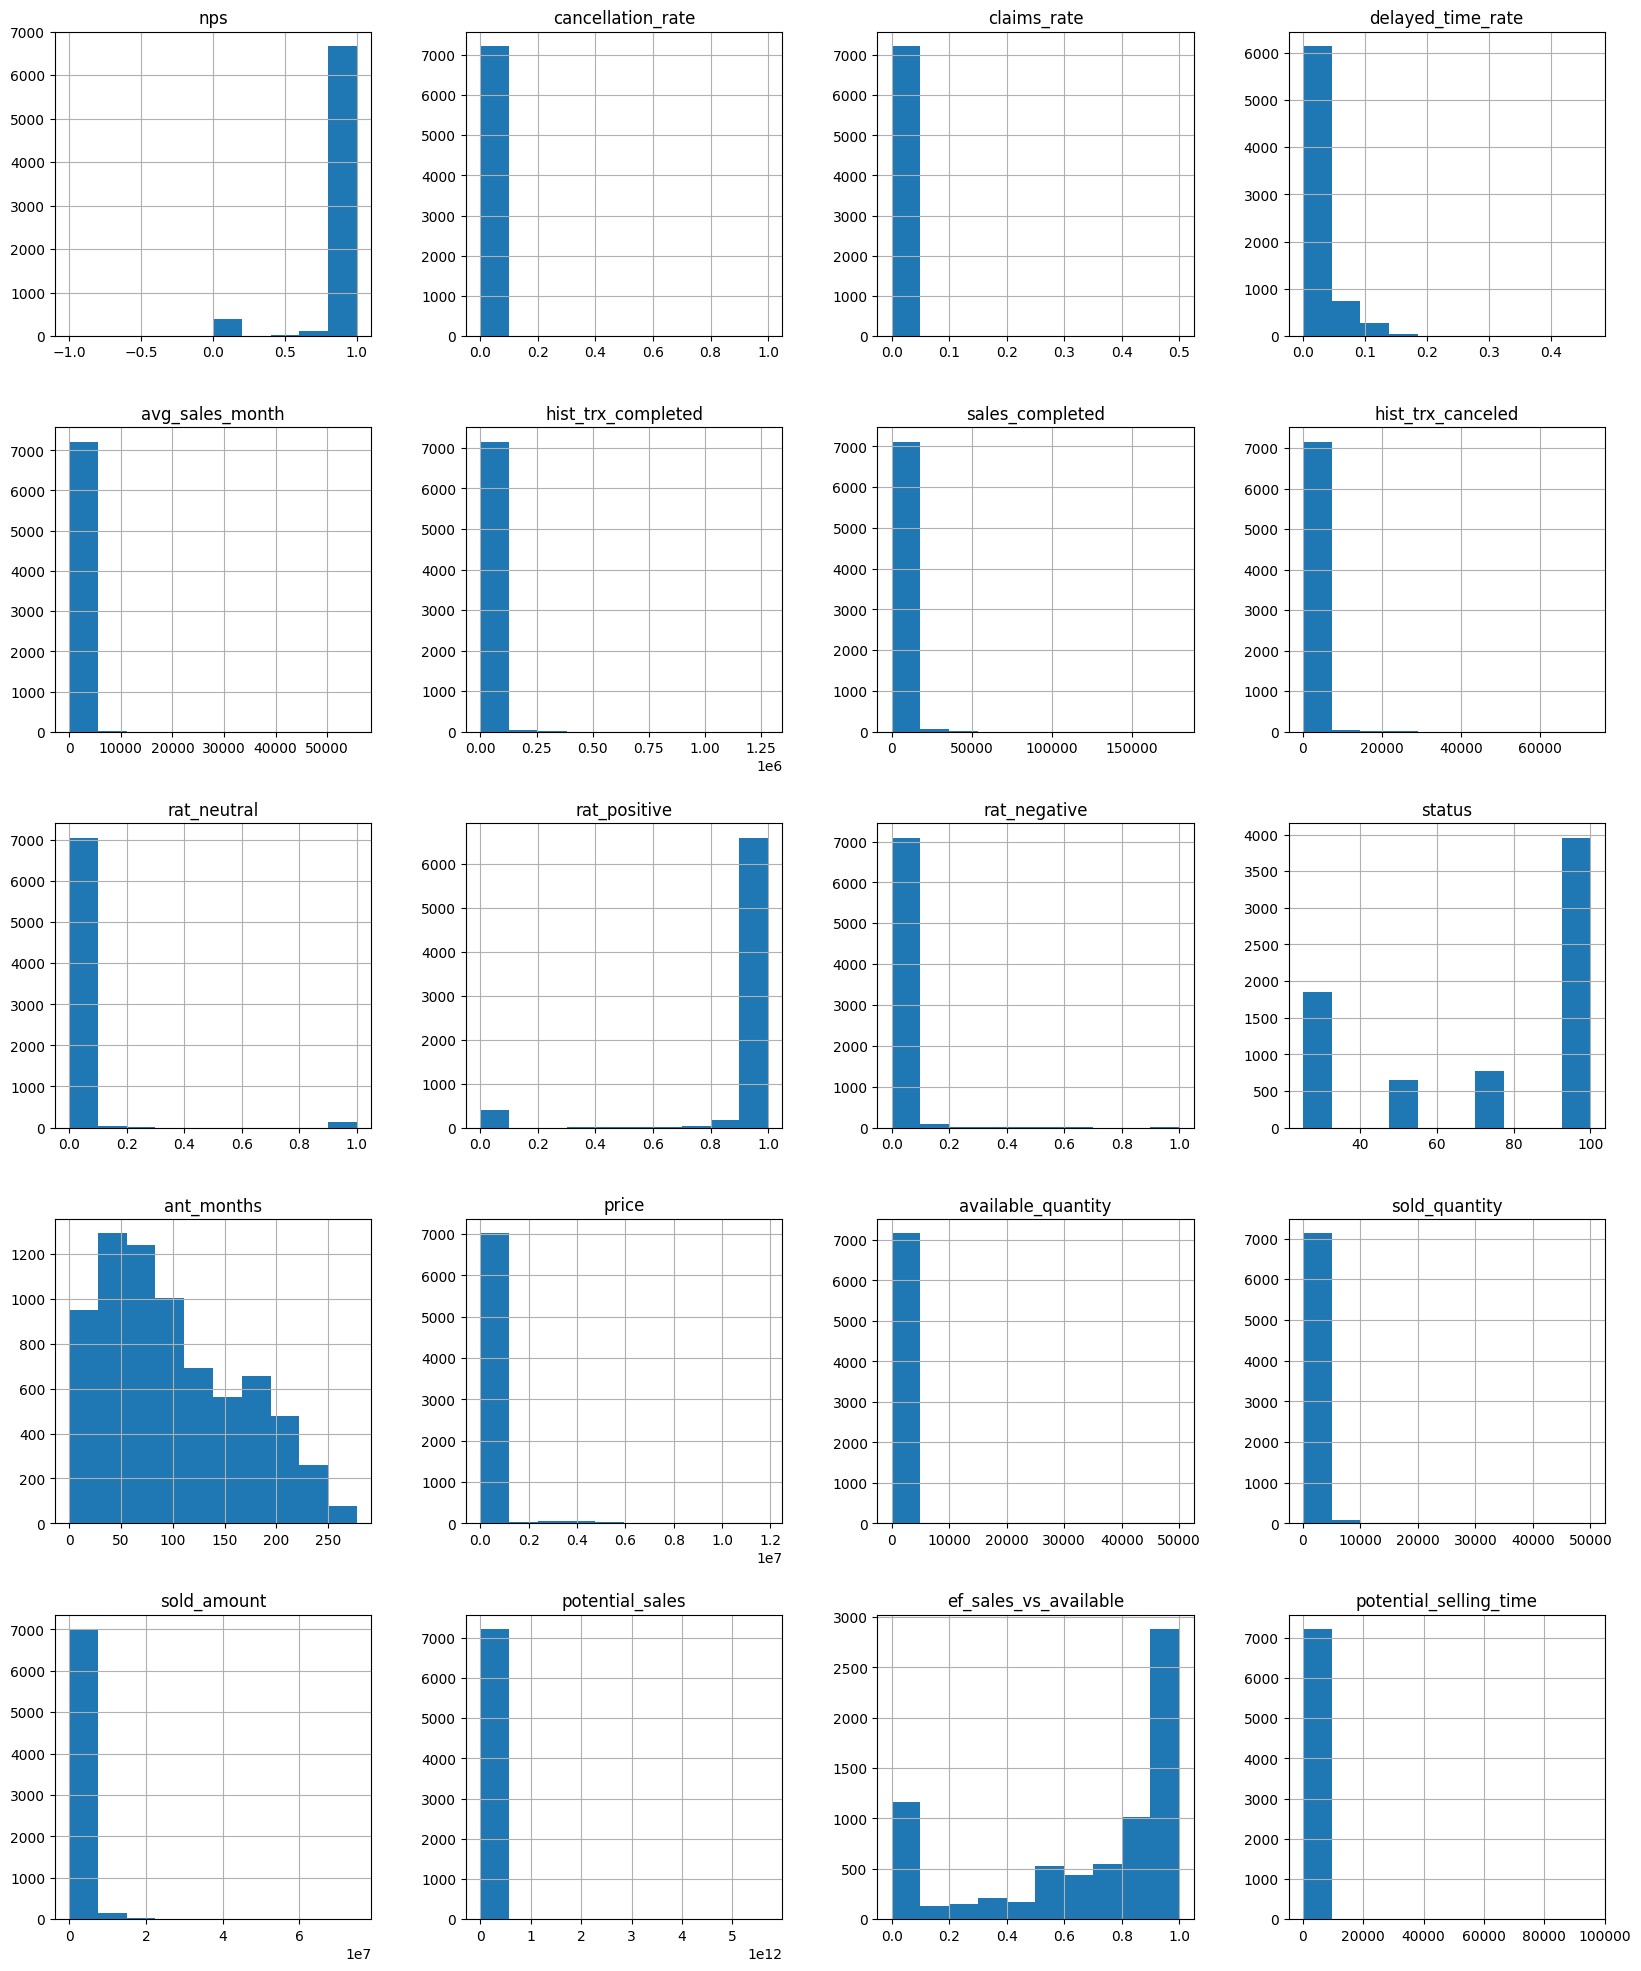

In [447]:
#Distribución de las variables

fig = plt.figure(figsize = (20,25))
ax = fig.gca()
df_final.hist(ax = ax)
plt.show()

#### Normalización de los datos

Para poder hacer las comparaciones correspondientes entre las variables, se realizó la normalización de los datos utilizando MinMaxScaler, un método que transforma las características de las variables a un rango (0,1)

In [448]:
#Normalización de los datos
scaler = MinMaxScaler()
data_scaler = df_final
data_scaler = pd.DataFrame(data = scaler.fit_transform(data_scaler), columns = data_scaler.columns, index=data_scaler.index)

#df_final-df_final.min()/(df_final.max()-df_final.min())

#### Outliers

In [449]:
#Tratamiento de outliers
cols = ['available_quantity', 'sold_quantity', 'delayed_time_rate', 'sold_amount','potential_sales',"avg_sales_month", 'potential_selling_time', "hist_trx_completed", "hist_trx_canceled", "price"] 

Q1 = data_scaler[cols].quantile(0.10)
Q3 = data_scaler[cols].quantile(0.90)
IQR = Q3 - Q1

data_scaler = data_scaler[~((data_scaler[cols] < (Q1 - 1.5 * IQR)) |(data_scaler[cols] > (Q3 + 1.5 * IQR))).any(axis=1)]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  """


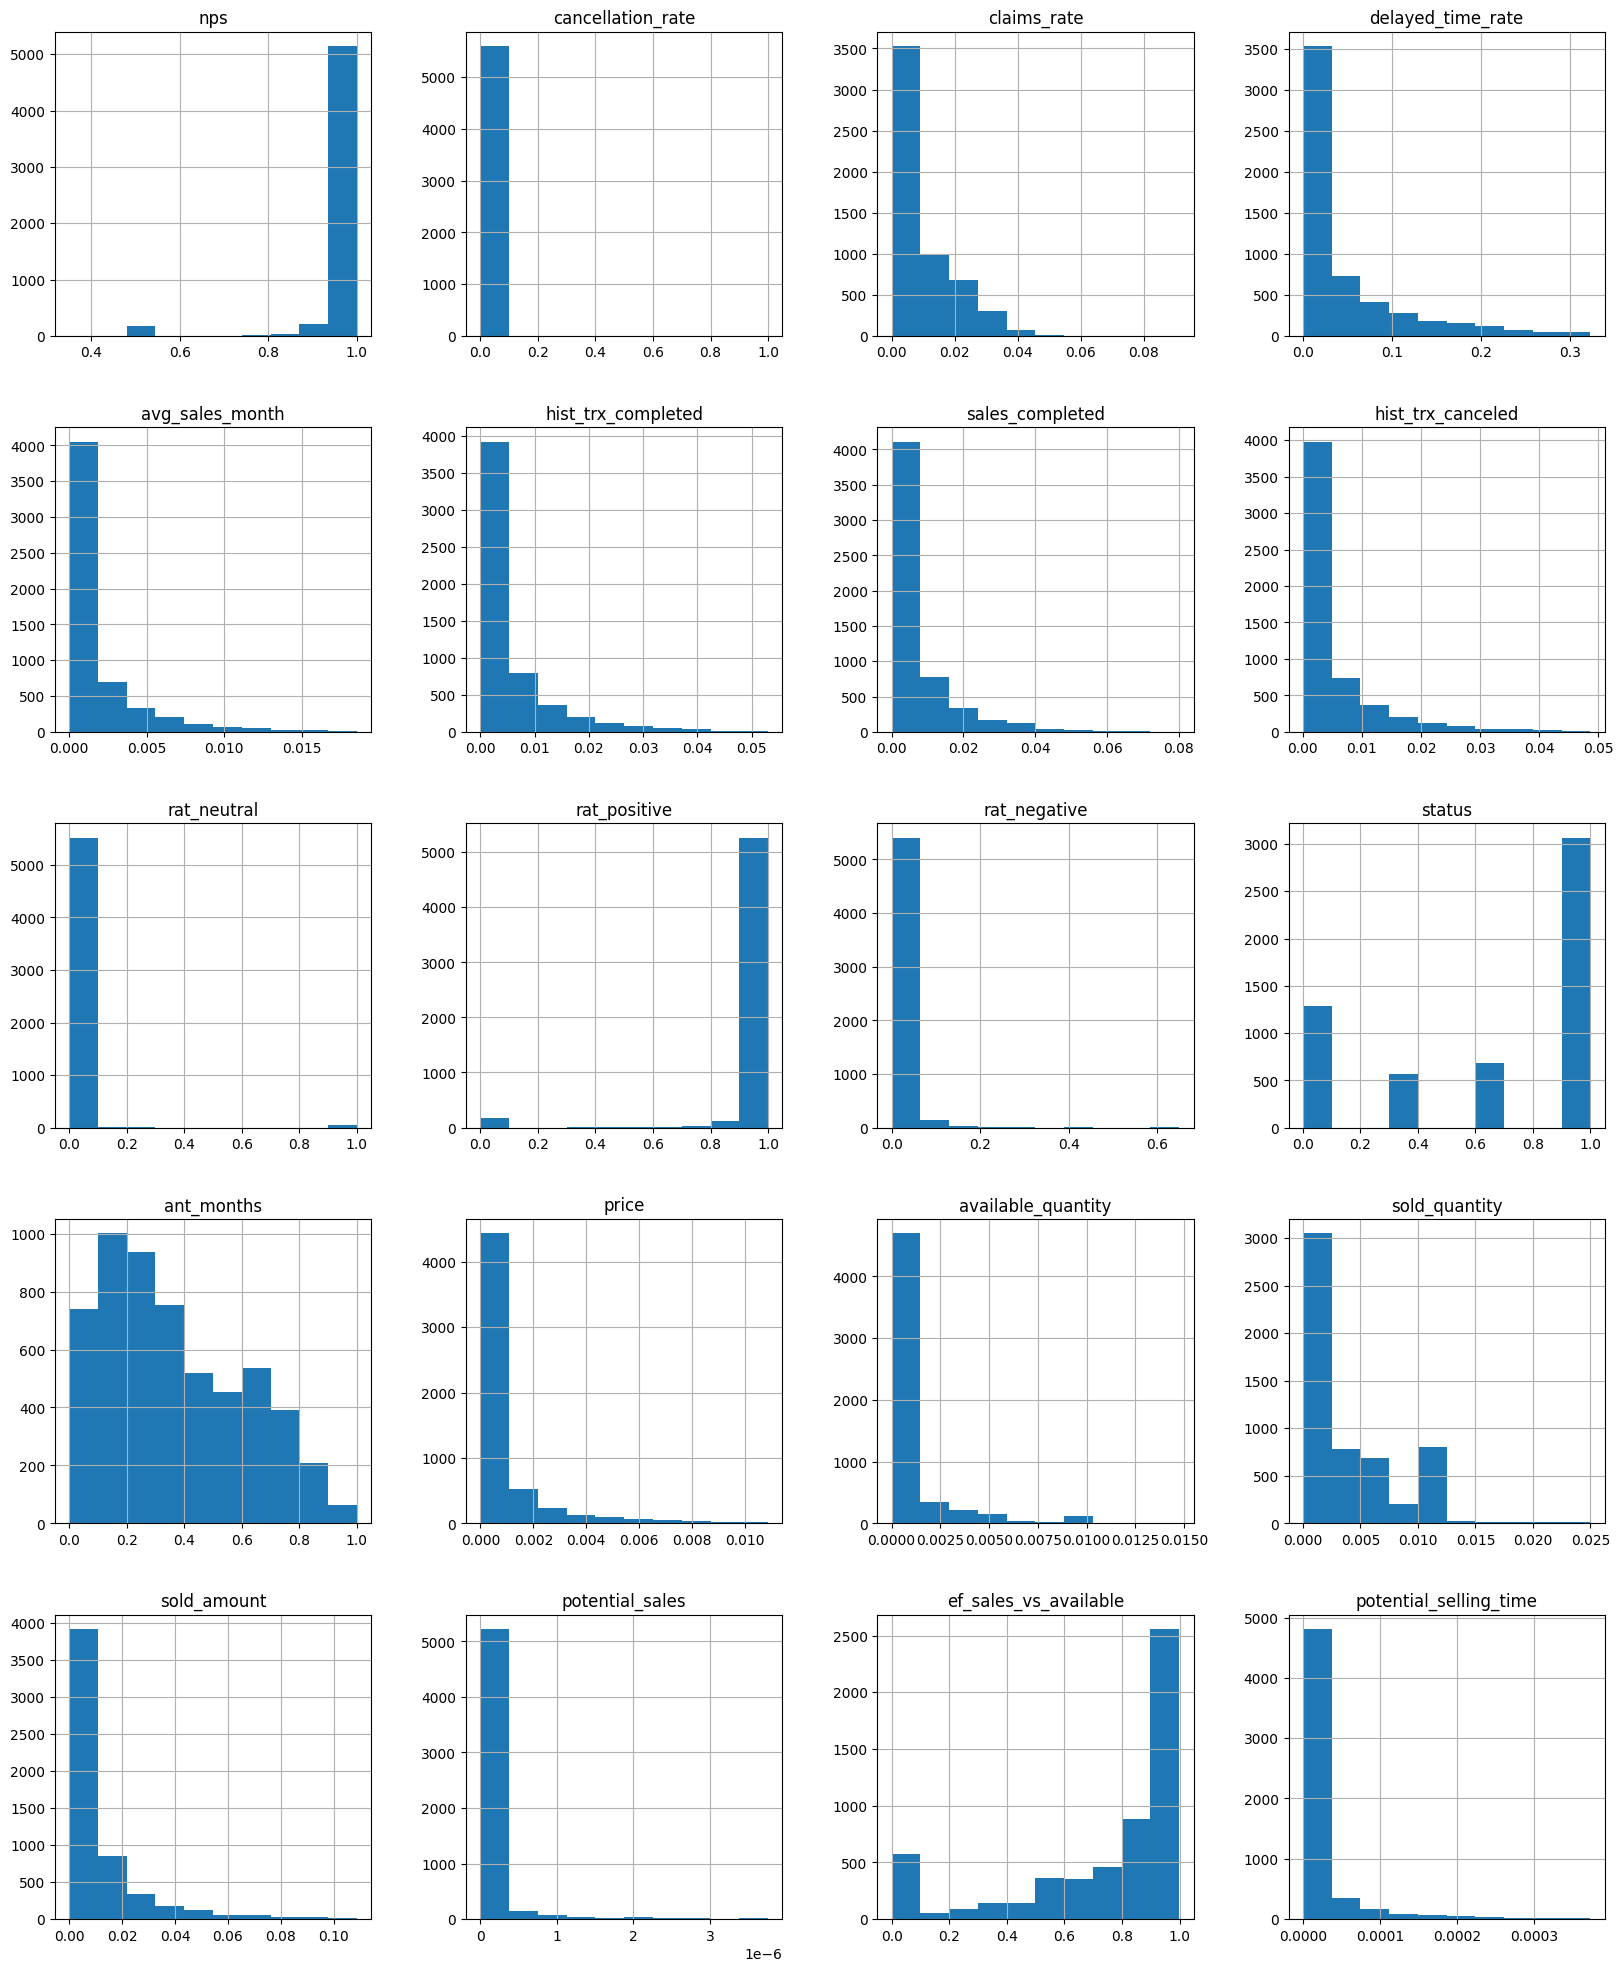

In [450]:
#Distribución de las variables sin outliers

fig = plt.figure(figsize = (20,25))
ax = fig.gca()
data_scaler.hist(ax = ax)
plt.show()

In [451]:
data_scaler.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5603 entries, 9590 to 1130056401
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   nps                     5603 non-null   float64
 1   cancellation_rate       5603 non-null   float64
 2   claims_rate             5603 non-null   float64
 3   delayed_time_rate       5603 non-null   float64
 4   avg_sales_month         5603 non-null   float64
 5   hist_trx_completed      5603 non-null   float64
 6   sales_completed         5603 non-null   float64
 7   hist_trx_canceled       5603 non-null   float64
 8   rat_neutral             5603 non-null   float64
 9   rat_positive            5603 non-null   float64
 10  rat_negative            5603 non-null   float64
 11  status                  5603 non-null   float64
 12  ant_months              5603 non-null   float64
 13  price                   5603 non-null   float64
 14  available_quantity      5603 no

Teniendo en cuenta la cantidad de outliers en las variables, se eliminaron los datos por encima del cuartil 90 y por debajo del cuartil 10, lo cual representó una pérdida del 22% de los datos. 

Cabe destacar que incluso después de realizar el ajuste, las distribuciones siguen mostrando un sesgo alto.

### Análisis de la información

Teniendo en cuenta la apreciación incial, se realizó la correlación entre las variables que inicialmente se consideraron relevantes para el estudio. Con esta información se seguirán depurando las variables significativas para el modelo.

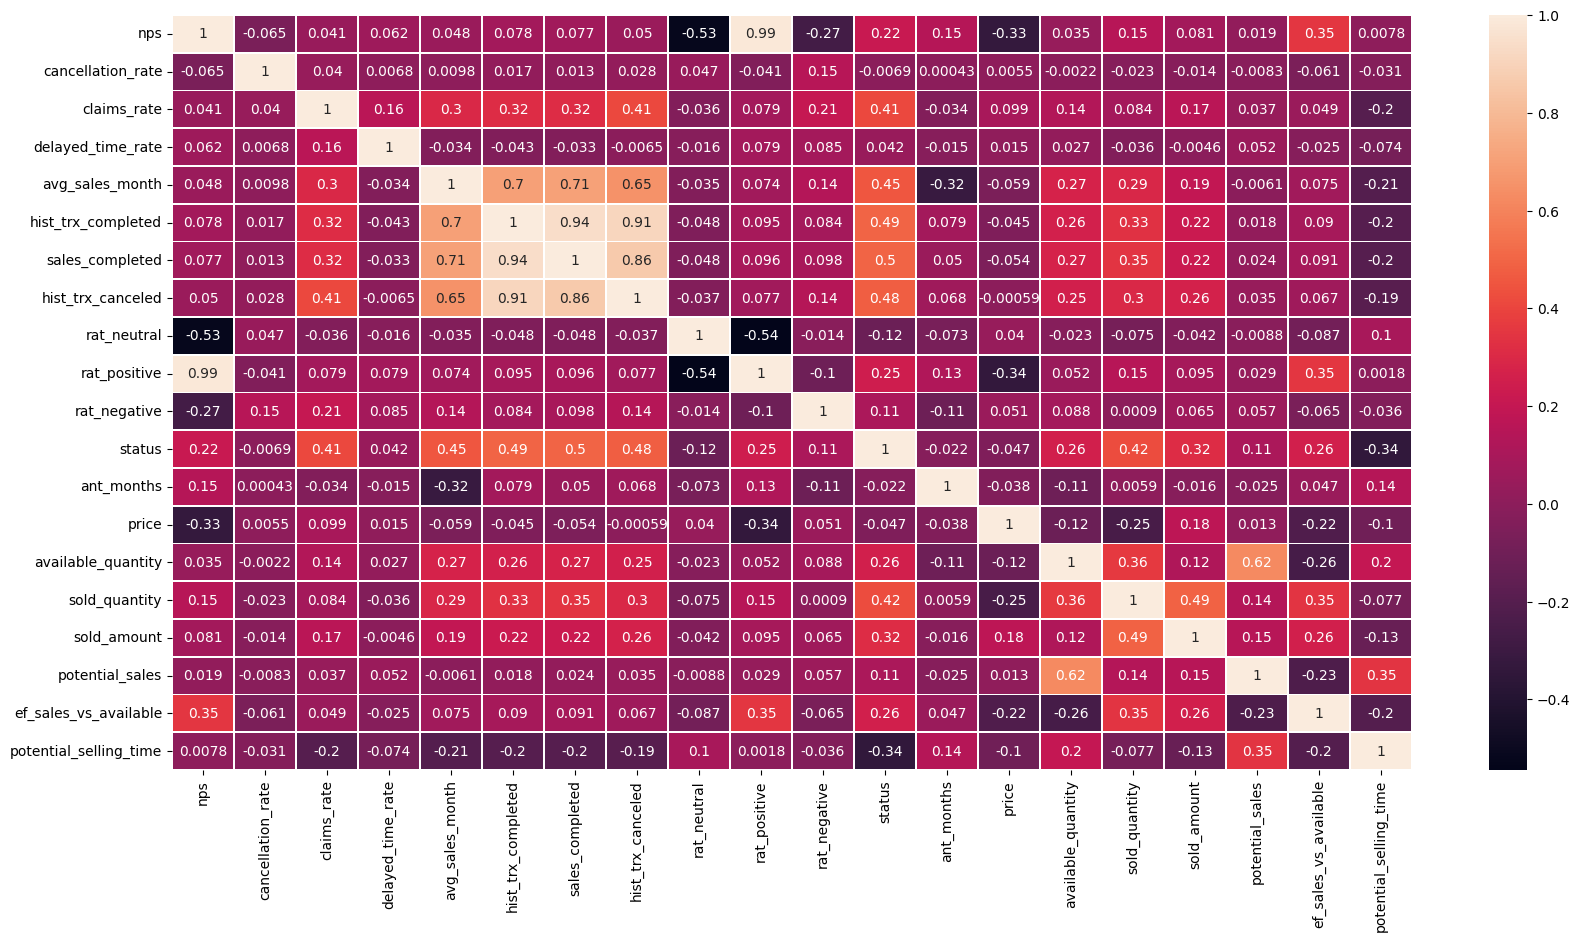

In [452]:
#Correlación entre las variables
fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(data_scaler.corr(), linewidths=.5, annot=True, ax=ax)

In [453]:
#Selección de las variables finales
data_scaler = data_scaler[["ef_sales_vs_available", "status", "claims_rate","ant_months", "sold_amount", "sold_quantity","nps", "potential_sales", "avg_sales_month",
                           "hist_trx_completed", "hist_trx_canceled", "potential_selling_time"
                          ]]

In [454]:
#Relación entre las variables
#pd.plotting.scatter_matrix(df_final, figsize=(20, 20))

In [455]:
#Análisis de regresión para ver la significancia de las variables
formula = 'sold_amount ~ + nps + claims_rate  + ant_months + potential_sales + potential_selling_time\
           + status + ef_sales_vs_available\
           + hist_trx_completed + hist_trx_canceled'
model = sm.ols(formula = formula, data = data_scaler)
fitted = model.fit()
print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:            sold_amount   R-squared:                       0.197
Model:                            OLS   Adj. R-squared:                  0.196
Method:                 Least Squares   F-statistic:                     152.7
Date:                Thu, 02 Jun 2022   Prob (F-statistic):          4.26e-259
Time:                        04:40:55   Log-Likelihood:                 15661.
No. Observations:                5603   AIC:                        -3.130e+04
Df Residuals:                    5593   BIC:                        -3.124e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0

Además del análisis de correlación, se realizó un modelo de regresión para determinar la significancia de las variables en el promedio del monto facturado por el vendedor, no obstante, las variables introducidas como predictores explican únicamente el 19% de variabilidad observada en las ventas.

En ese orden de ideas, se plantearán dos soluciones para abordar el problema: 

1. La construcción de un modelo de ML no supervisado (K means)
2. La construcción de un score teniendo en cuenta la distribución de las variables seleccionadas.

### Implementación de modelos

### Modelo 1: K Means

El clustering consiste en la agrupación automática de datos. Al ser un aprendizaje no-supervisado, la evaluación de los grupos identificados dependerá de la relación que nos arroje el cluster con las variables que se presentan. 

Inicialmente, se realizará un análisis de componentes principales y luego se realizará la implementación del modelo.

#### Reducción de dimensionalidad: Análisis de Componentes Principales (PCA)

In [458]:
#Selección de las variables
#df_final = df_final.set_index("seller.id")
df_PCA = pd.DataFrame(data = scaler.fit_transform(df_final), columns = df_final.columns, index=df_final.index)
df_PCA = df_PCA[["nps", "sold_amount","ant_months", "ef_sales_vs_available", "potential_selling_time", "status", "avg_sales_month"]]

In [477]:
from sklearn.decomposition import PCA
# El objeto de tipo PCA indica la cantidad de componentes que se desean encontrar
pca = PCA(n_components=4)

In [478]:
principalComponents = pca.fit_transform(df_PCA)

In [479]:
projected_data = pd.DataFrame(principalComponents, columns = ['pc1', 'pc2', 'pc3', 'pc4'])

In [480]:
projected_data

,pc1,pc2,pc3,pc4
0,0.382478,-0.650385,0.251241,-0.022099
1,-0.430101,-0.067741,0.307952,0.039058
2,0.306079,-0.160565,0.615425,-0.014451
3,0.094745,-0.484022,0.266753,-0.003032
4,-0.176089,-0.322220,0.597025,0.053856
...,...,...,...,...
7219,0.534497,-0.326071,-0.387938,-0.112532
7220,0.948400,0.317512,-0.334515,0.302235
7221,0.948400,0.317512,-0.334515,0.302235
7222,0.948402,0.317527,-0.334633,0.302225


In [481]:
# Se extraen los pesos con los que se ponderan las variables para generar los componentes principales
pca.components_ 

array([[-1.06681581e-01, -2.33694249e-02, -1.63073519e-02,
        -5.04652379e-01,  2.02157723e-03, -8.56214654e-01,
        -5.03350261e-03],
       [-7.76451534e-02,  3.25127159e-04, -1.28836185e-01,
        -8.46344765e-01,  1.31807732e-03,  5.10930166e-01,
         4.63990437e-03],
       [ 7.51636913e-02,  1.04787175e-03,  9.87670270e-01,
        -1.28544656e-01,  1.54736350e-03,  4.76100034e-02,
        -7.99529686e-03],
       [-9.88300034e-01,  1.54157518e-02,  8.69751092e-02,
         1.11002519e-01, -6.75082761e-03,  5.56184859e-02,
         4.22035637e-04]])

In [482]:
# Varianza explicada por cada componente
print(pca.explained_variance_ratio_)
# Varianza acumulada
print(pca.explained_variance_ratio_.cumsum())

[0.56533389 0.25600114 0.14472518 0.02726751]
[0.56533389 0.82133503 0.96606021 0.99332772]


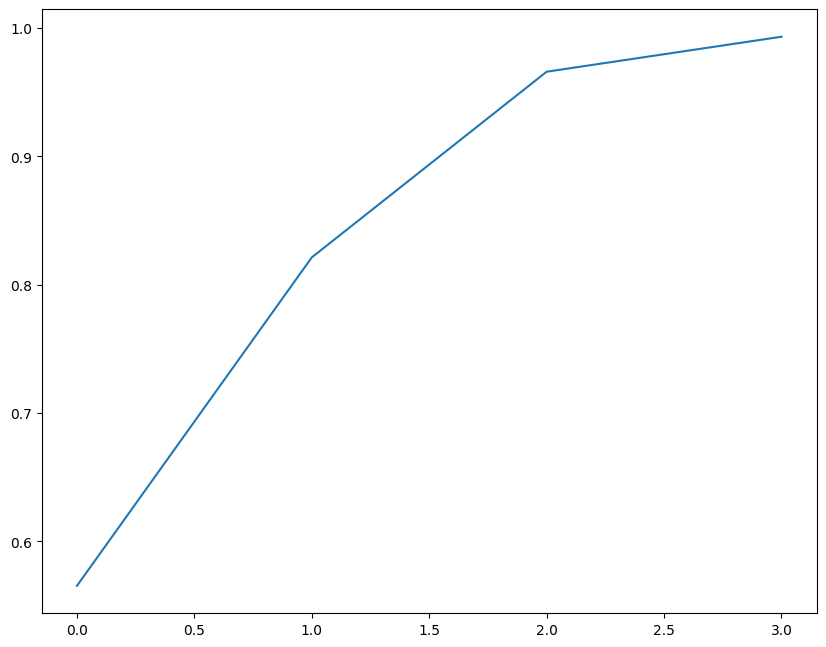

In [483]:
# Varianza acumulada
plt.plot(range(4), pca.explained_variance_ratio_.cumsum())

En este caso, el primer componente explica el 56% de la varianza observada en los datos y la segunda el 25%, por lo que si se empleasen únicamente los dos primeros componentes se conseguiría explicar el 82% de la varianza observada.

In [476]:
#Se calcula nuevamente con los componentes 
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(df_PCA)
projected_data_opt = pd.DataFrame(principalComponents, columns = ['pc1', 'pc2'])

#### Implementación K-means

In [485]:
#Selección de número de categorías
varianzas = []

for k in range(1,21):
    clust = KMeans(n_clusters=k)
    clust.fit(df_PCA)
    varianzas.append(clust.inertia_) # Clust.intertia_ indica la suma de las varianzas internas de los grupos, justamente lo que se desea minimizar con el algoritmo


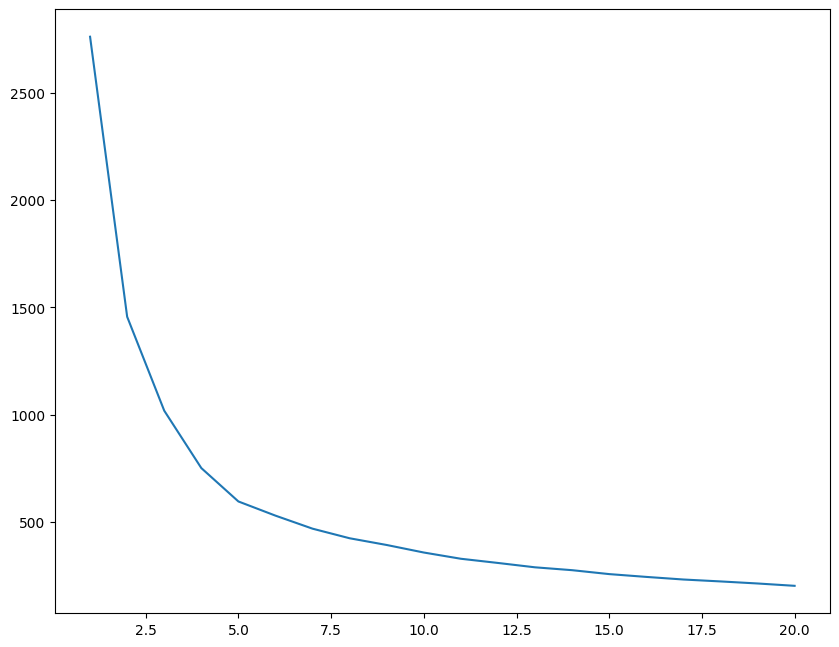

In [486]:
# Graficamos el resultado variando el número de clusters, buscando un codo en la gráfica
plt.plot(range(1,21), varianzas)

La idea básica de los algoritmos de clustering es la minimización de la varianza intra-cluster y la maximización de la varianza inter-cluster. El método del codo utiliza la distancia media de las observaciones a su centroide. Es decir, se fija en las distancias intra-cluster. 

En este caso, para el modelo se van a utilizar 4 clusters.

In [487]:
from sklearn.cluster import KMeans
# Generamos el número de grupos escogido
clusters = KMeans(n_clusters=4)
clusters = clusters.fit(df_PCA) 
projected_data_opt['cluster'] = clusters.predict(df_PCA)

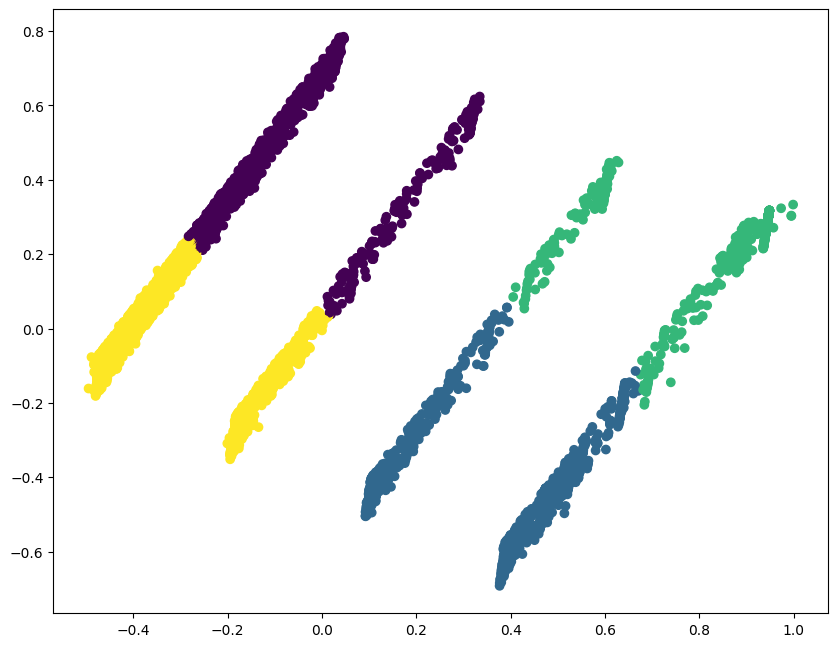

In [488]:
plt.scatter(projected_data_opt['pc1'], projected_data_opt['pc2'], c = projected_data_opt['cluster']);

In [489]:
df_PCA["Cluster"] = clusters.predict(df_PCA)

In [490]:
df_PCA

,nps,sold_amount,ant_months,ef_sales_vs_available,potential_selling_time,status,avg_sales_month,Cluster
seller.id,,,,,,,,
9590,1.000,0.000460,0.685052,0.993576,4.475310e-06,0.000000,0.000042,1
39092,0.985,0.000446,0.684571,0.910294,4.813197e-07,1.000000,0.000391,3
60438,0.990,0.007973,0.983538,0.571543,7.487481e-04,0.333333,0.000038,1
83182,1.000,0.000000,0.685292,0.998204,4.340627e-06,0.333333,0.000043,1
101217,0.985,0.012967,1.000000,0.961731,2.106399e-06,0.666667,0.000089,3
...,...,...,...,...,...,...,...,...
1125604025,1.000,0.000433,0.001562,0.714429,1.866282e-06,0.000000,0.000101,1
1129675466,0.500,0.000000,0.000721,0.000000,0.000000e+00,0.000000,0.000000,2
1129786918,0.500,0.000000,0.000721,0.000000,0.000000e+00,0.000000,0.000000,2


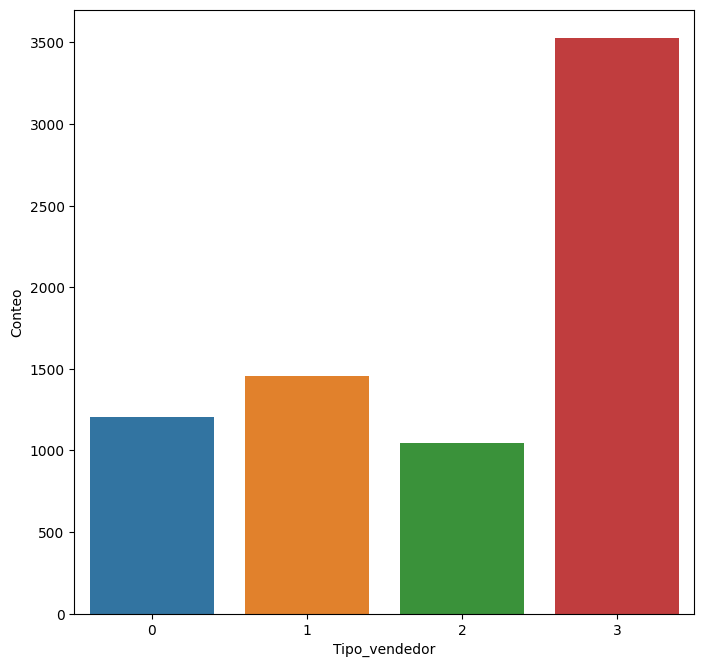

,Tipo_vendedor,Conteo
0,3,3525
1,1,1453
2,0,1203
3,2,1043


In [491]:
#Distribución de los vendedores
plt.figure(figsize=(8, 8))
plt2 = df_PCA.Cluster.value_counts().reset_index()
plt2.columns = ["Tipo_vendedor", "Conteo"]
sns.barplot(x='Tipo_vendedor', y='Conteo', data=plt2)
plt.show()
plt2

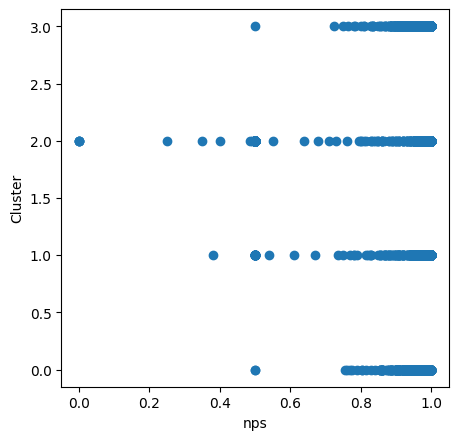

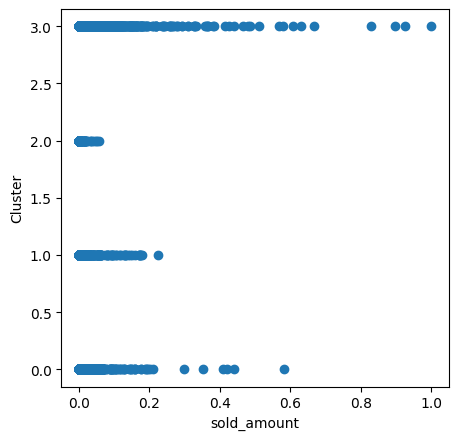

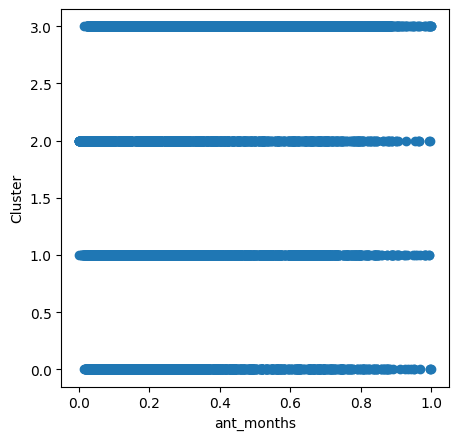

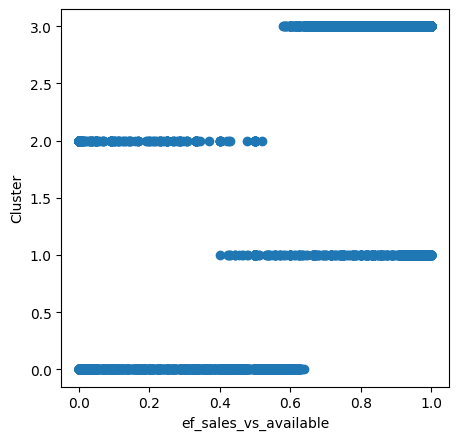

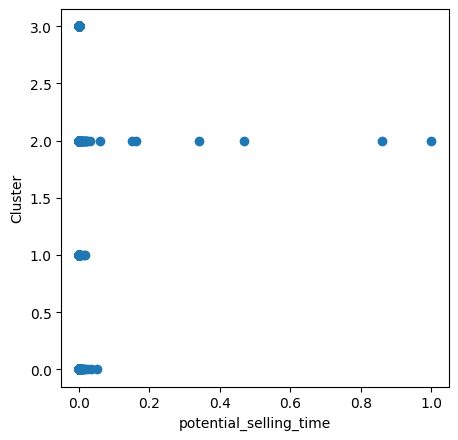

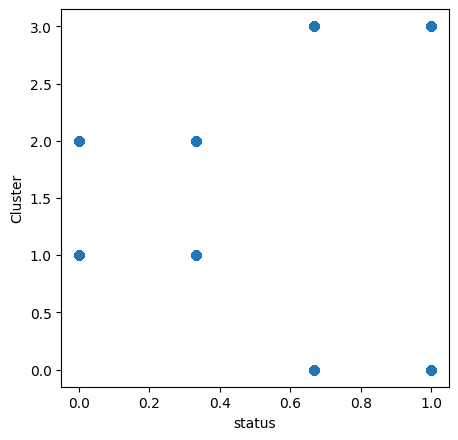

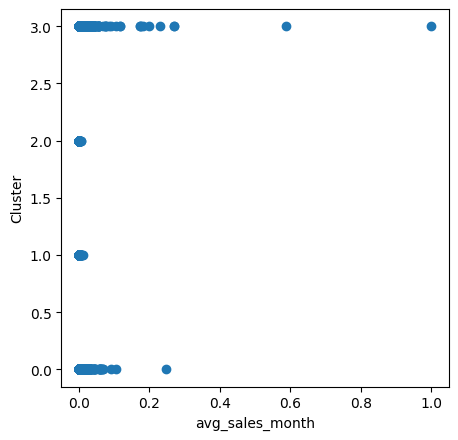

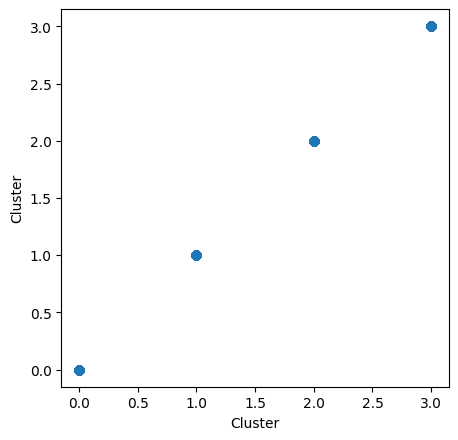

In [493]:
for i in df_PCA.columns:
  fig, ax = plt.subplots(figsize=(5, 5))

  x_name = i 
  y_name = "Cluster"
  x = df_PCA[{x_name}]
  y = df_PCA[{y_name}]

  plt.scatter(x, y)

  plt.xlabel(x_name)
  plt.ylabel(y_name)

  plt.show()

Con la información obtenida, podemos concluir que la clusterización no es lo suficientemente acertada para clasificar a los clientes. 

Si bien el cluster 3 es el que clasifica a los mejores vendedores, no hay una tendencia clara sobre todas las variables. Esto puede estar relacionado con la cantidad de outliers que tenemos y el sesgo de las variables.

#### Implementación alternativa - Percentiles

In [382]:
def percentiles(series):
  orden= series.sort_values() #Ordena los valores
  zeros = (orden == 0).sum()/orden.shape[0] #Divide el total de filas con valor cero sobre el total de filas
  print(zeros)
  perc = np.cumsum(orden.apply(lambda x:0 if x==0 else 1))/orden.shape[0] #Ordenar a los clientes según su distribución
  perc = perc.apply(lambda x:0 if np.floor((x)*100)==0 else np.floor((x+zeros)*100)) #Redondeo de los datos
  return perc

def percentiles_desc(series):
  orden= series.sort_values(ascending=False) #Ordena los valores desc
  zeros = (orden == 0).sum()/orden.shape[0] #Divide el total de filas con valor cero sobre el total de filas
  print(zeros)
  perc = np.cumsum(orden.apply(lambda x:0 if x==0 else 1))/orden.shape[0] #Ordenar a los clientes según su distribución
  perc = perc.apply(lambda x:0 if np.floor((x)*100)==0 else np.floor((x+zeros)*100)) #Redondeo de los datos
  return perc

In [494]:
def score_vendedor(df):
  antiguedad = percentiles(df['ant_months'])
  efectividad = percentiles(df["ef_sales_vs_available"])
  facturacion_2m = percentiles(df["sold_amount"])
  nps = percentiles(df["nps"])
  prom_ventas = percentiles(df["avg_sales_month"])
  tiempo_esperado_venta = percentiles_desc(df["potential_selling_time"])
  status = percentiles(df["status"])
  score = antiguedad + efectividad + facturacion_2m + nps + prom_ventas + tiempo_esperado_venta + status
  score = score/ 7
  print(len(score))
  return score

0.0
0.12610741971207087
0.14770210409745294
0.0555094130675526
0.05011074197120709
0.05011074197120709
0.0
7224


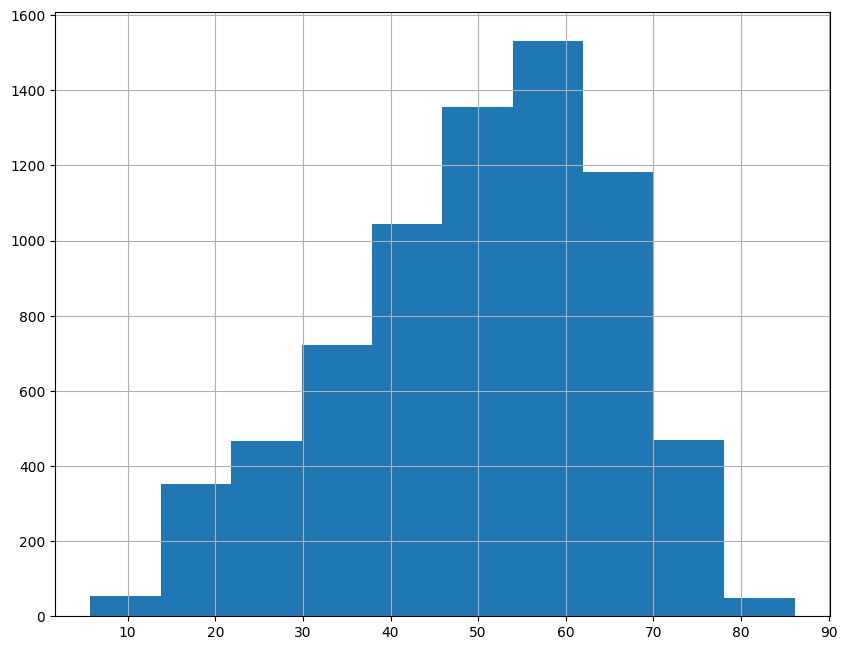

In [495]:
df_final = df_final.reset_index()
score_vendedor(df_final).hist()

In [496]:
# Crear Score en el dataframe
df_final_m1 = df_final.copy()
df_final_m1['Score'] = score_vendedor(df_final)
df_final_m1

0.0
0.12610741971207087
0.14770210409745294
0.0555094130675526
0.05011074197120709
0.05011074197120709
0.0
7224


,seller.id,nps,cancellation_rate,claims_rate,delayed_time_rate,avg_sales_month,hist_trx_completed,sales_completed,hist_trx_canceled,rat_neutral,rat_positive,rat_negative,status,ant_months,price,available_quantity,sold_quantity,sold_amount,potential_sales,ef_sales_vs_available,potential_selling_time,Score
0,9590,1.00,0.0000,0.0,0.0000,2.345722,446,95,8,0.00,1.00,0.00,25.0,190.133333,230.000,1.0,150.000,34500.000,9.805082e+01,0.993377,0.426308,52.857143
1,39092,0.97,0.0065,0.0,0.0105,21.810526,4144,732,179,0.01,0.98,0.01,100.0,190.000000,1189.625,1.0,10.125,33449.375,5.418908e+01,0.910112,0.045849,58.714286
2,60438,0.98,0.0000,0.0,0.1280,2.103078,574,127,23,0.00,0.99,0.01,50.0,272.933333,2990.000,150.0,200.000,598000.000,3.198883e+07,0.571429,71.324042,44.571429
3,83182,1.00,0.0000,0.0,0.0000,2.418507,460,58,0,0.00,1.00,0.00,50.0,190.200000,0.000,1.0,500.000,0.000,0.000000e+00,0.998004,0.413478,53.428571
4,101217,0.97,0.0000,0.0,0.0000,4.983784,1383,190,77,0.01,0.98,0.01,75.0,277.500000,38900.000,1.0,25.000,972500.000,7.805315e+03,0.961538,0.200651,60.714286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7219,1125604025,1.00,0.0000,0.0,0.0000,5.625000,3,3,1,0.00,1.00,0.00,25.0,0.533333,11499.000,1.0,2.500,32497.500,2.044267e+03,0.714286,0.177778,36.000000
7220,1129675466,0.00,0.0000,0.0,0.0000,0.000000,0,0,0,0.00,0.00,0.00,25.0,0.300000,89000.000,1.0,0.000,0.000,0.000000e+00,0.000000,0.000000,16.142857
7221,1129786918,0.00,0.0000,0.0,0.0000,0.000000,0,0,0,0.00,0.00,0.00,25.0,0.300000,14000.000,1.0,0.000,0.000,0.000000e+00,0.000000,0.000000,16.142857
7222,1129987441,0.00,0.0000,0.0,0.0000,0.000000,0,0,0,0.00,0.00,0.00,25.0,0.266667,12000.000,1.0,0.000,0.000,0.000000e+00,0.000000,0.000000,14.714286


##### Asignación de categoría con Quantile-based discretization function.

In [497]:
df_final_m1['Tipo_Vendedor'] = pd.qcut(df_final_m1["Score"],4,labels=["No Rentable", "Zona Gris", "Oportunidad", "Rentable"])
df_final_m1.sort_values(by = "Score", ascending = False)

,seller.id,nps,cancellation_rate,claims_rate,delayed_time_rate,avg_sales_month,hist_trx_completed,sales_completed,hist_trx_canceled,rat_neutral,rat_positive,rat_negative,status,ant_months,price,available_quantity,sold_quantity,sold_amount,potential_sales,ef_sales_vs_available,potential_selling_time,Score,Tipo_Vendedor
1762,77604177,0.99,0.0007,0.0012,0.0220,305.548589,64980,9198,1455,0.01,0.99,0.00,100.0,212.666667,1.665211e+03,1.0,1447.368421,1.462605e+06,5.446089e+00,0.999310,0.003273,86.142857,Rentable
641,27598064,1.00,0.0065,0.0032,0.0029,32.356893,7386,1163,362,0.00,1.00,0.00,100.0,228.266667,4.813900e+03,1.0,500.000000,2.406950e+06,1.478081e+02,0.998004,0.030905,84.857143,Rentable
3275,161127761,0.99,0.0010,0.0022,0.0072,360.165289,34864,4674,1157,0.01,0.99,0.00,100.0,96.800000,2.580000e+03,1.0,500.000000,1.290000e+06,7.156214e+00,0.998004,0.002777,83.285714,Rentable
347,13232084,0.99,0.0073,0.0086,0.0177,94.716029,22514,3555,955,0.01,0.99,0.00,100.0,237.700000,8.000000e+02,1.0,2750.000000,3.325000e+06,8.384642e+00,0.999636,0.010558,82.428571,Rentable
884,39384567,0.94,0.0072,0.0078,0.0198,535.076379,95743,12438,6077,0.02,0.96,0.02,100.0,178.933333,2.868000e+03,1.0,1277.272727,1.913864e+06,5.321391e+00,0.999218,0.001869,82.285714,Rentable
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7163,1041474410,0.00,0.0000,0.0000,0.0000,0.179641,1,1,0,1.00,0.00,0.00,25.0,5.566667,3.500000e+06,1.0,0.000000,0.000000e+00,1.948333e+07,0.000000,5.566667,6.428571,No Rentable
5931,440466559,0.00,0.0000,0.0000,0.0000,0.027322,1,1,0,1.00,0.00,0.00,25.0,36.600000,7.000000e+03,1.0,0.000000,0.000000e+00,2.562000e+05,0.000000,36.600000,6.428571,No Rentable
7021,789965412,0.00,0.0000,0.0000,0.0000,0.092308,1,1,1,1.00,0.00,0.00,25.0,10.833333,3.537143e+06,1.0,0.000000,0.000000e+00,3.831905e+07,0.000000,10.833333,6.142857,No Rentable
6273,511837901,-0.50,0.0000,0.0000,0.0000,0.034247,1,1,8,0.00,0.25,0.75,25.0,29.200000,1.650000e+05,1.0,0.000000,0.000000e+00,4.818000e+06,0.000000,29.200000,5.857143,No Rentable


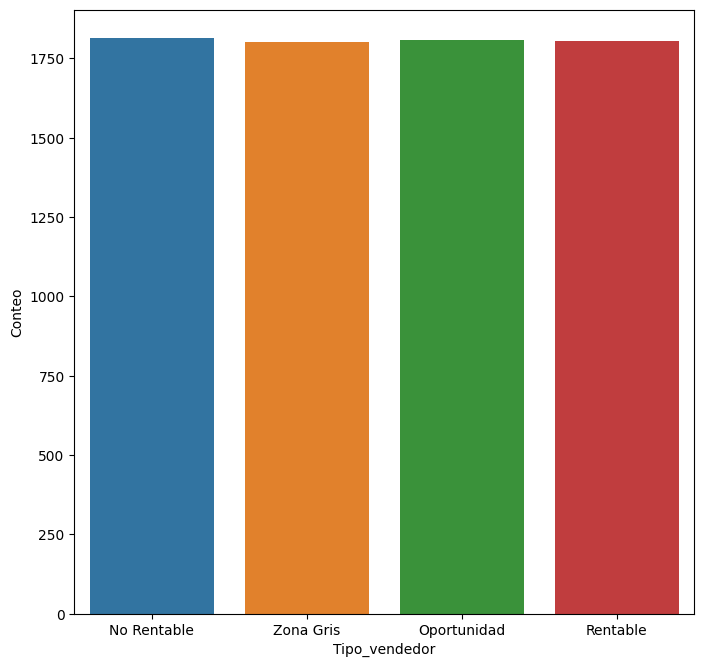

,Tipo_vendedor,Conteo
0,No Rentable,1813
1,Oportunidad,1807
2,Rentable,1804
3,Zona Gris,1800


In [498]:
plt.figure(figsize=(8, 8))
plt1 = df_final_m1.Tipo_Vendedor.value_counts().reset_index()
plt1.columns = ["Tipo_vendedor", "Conteo"]
sns.barplot(x='Tipo_vendedor', y='Conteo', data=plt1)
plt.show()
plt1

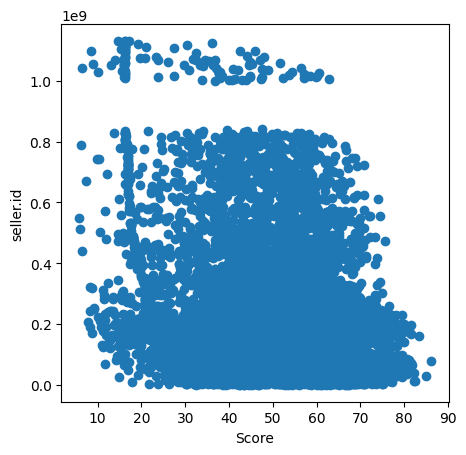

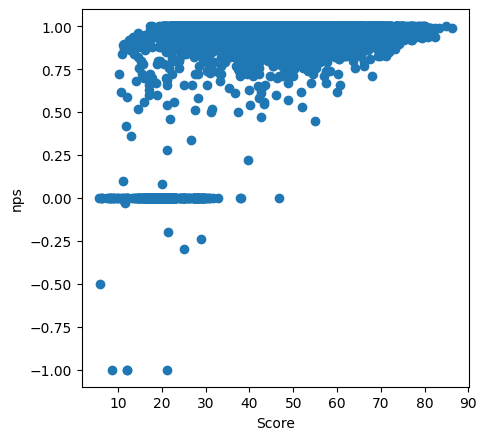

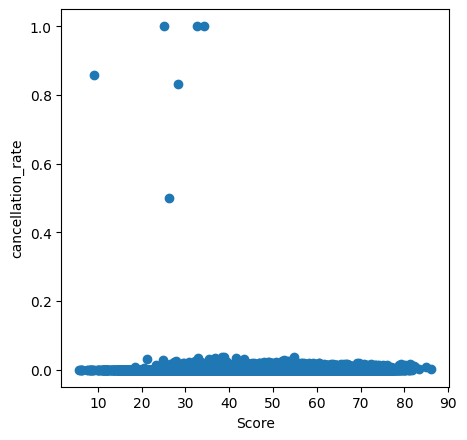

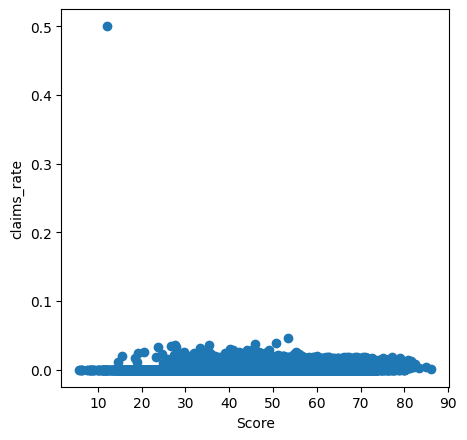

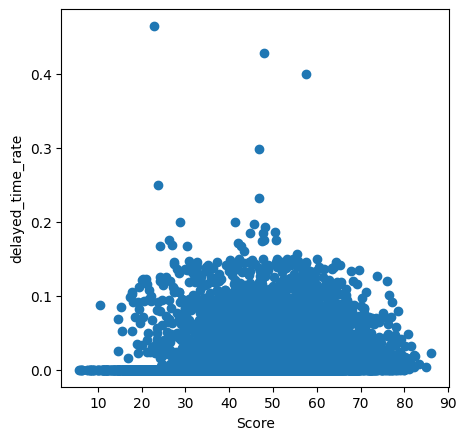

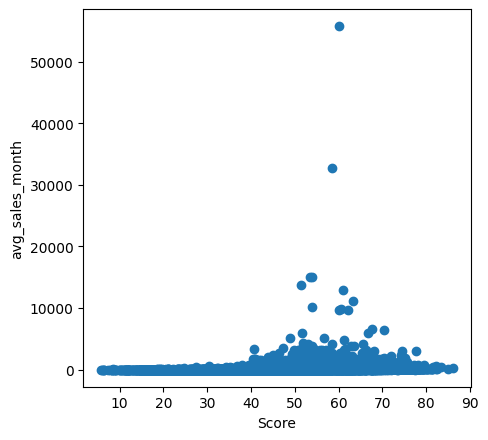

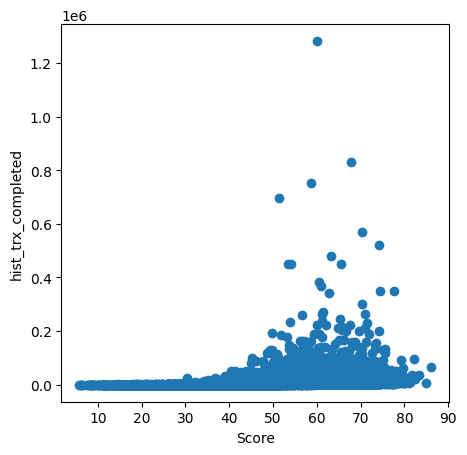

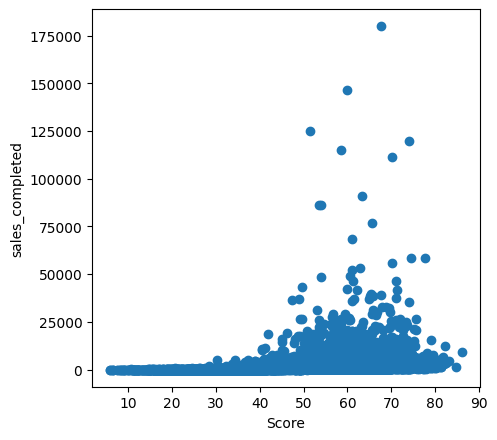

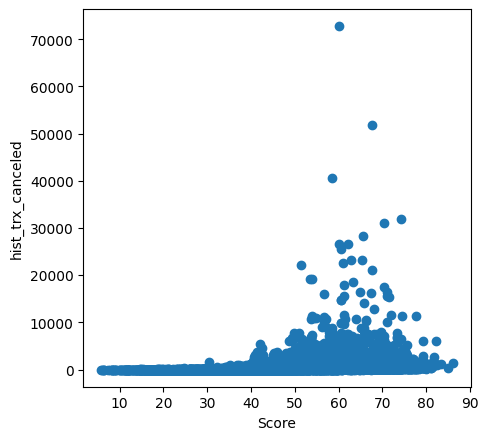

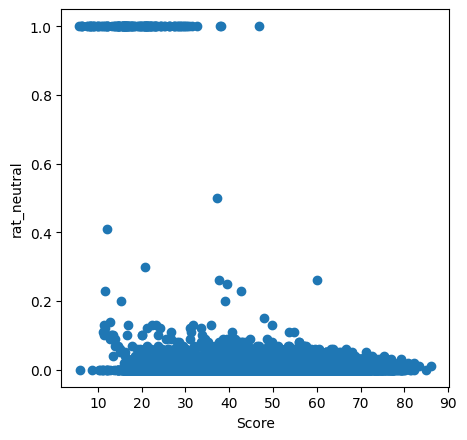

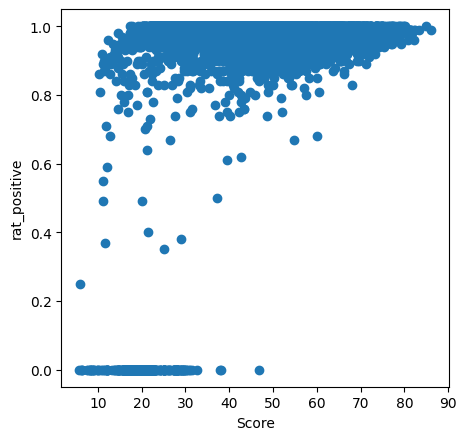

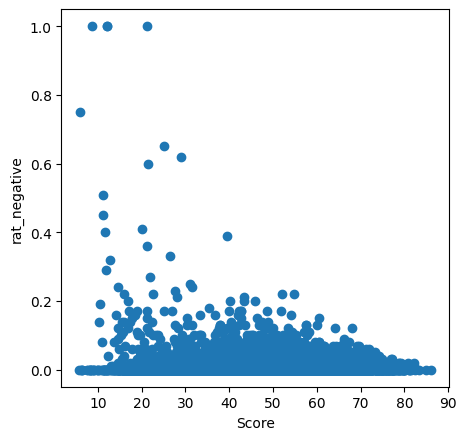

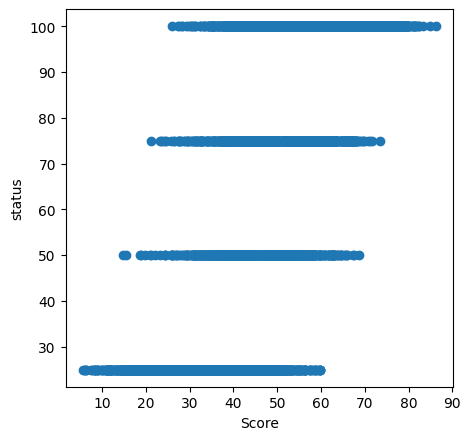

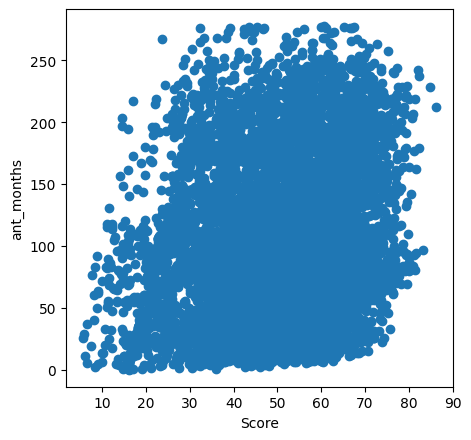

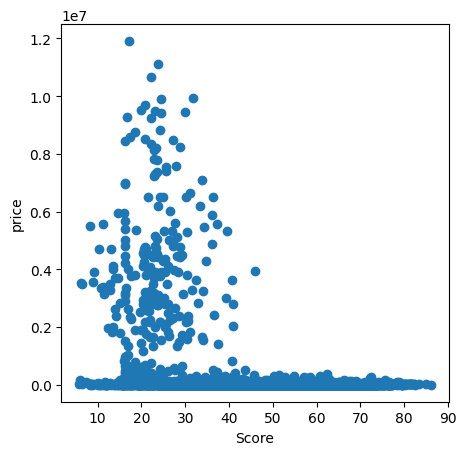

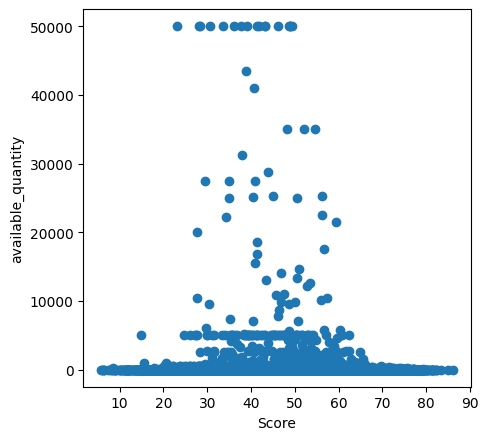

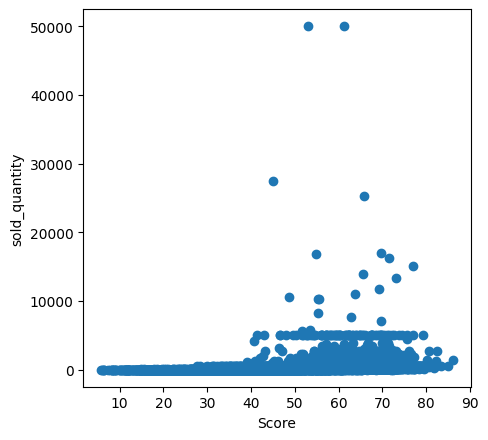

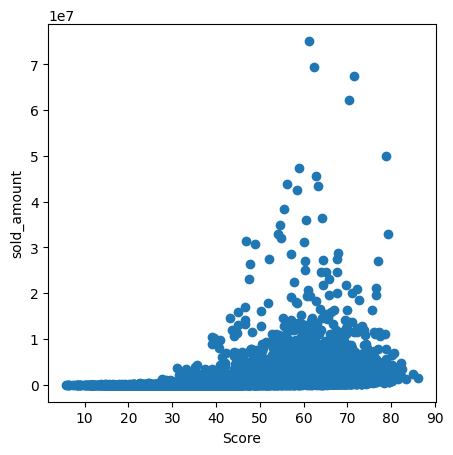

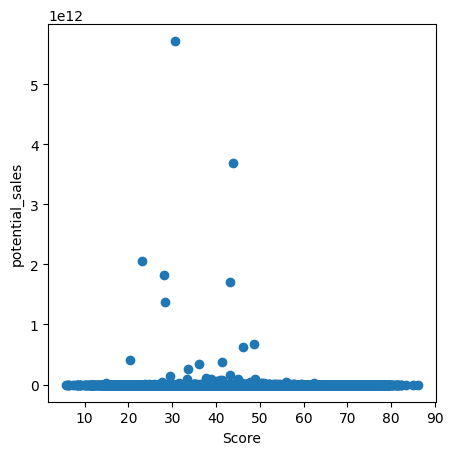

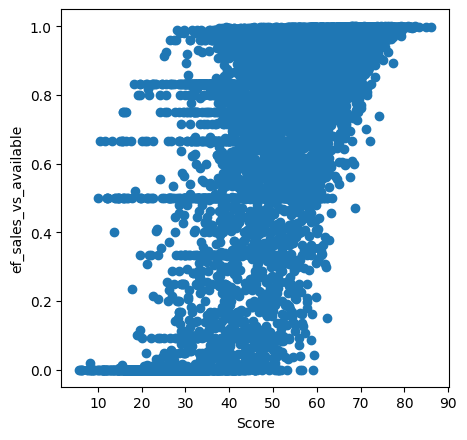

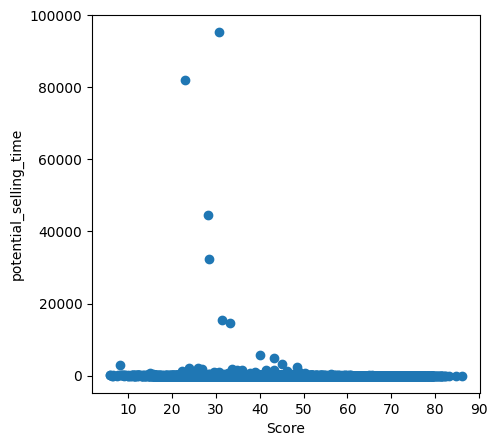

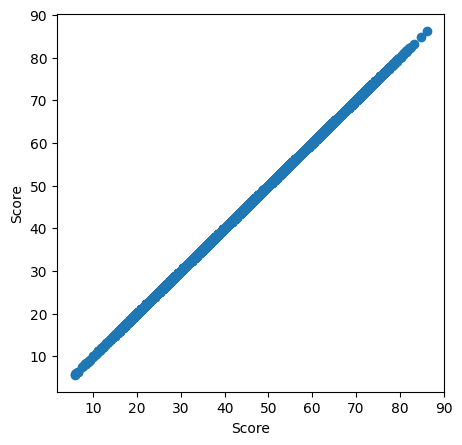

TypeError: ignored

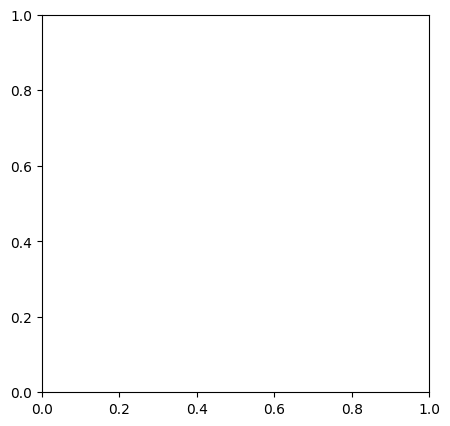

In [500]:
for i in df_final_m1.columns:
  fig, ax = plt.subplots(figsize=(5, 5))

  x_name = "Score" 
  y_name = i
  x = df_final_m1[{x_name}]
  y = df_final_m1[{y_name}]

  plt.scatter(x, y)

  plt.xlabel(x_name)
  plt.ylabel(y_name)

  plt.show()

Al realizar la clasificación de los vendedores por percentiles, la relación entre el score y las variables es mucho más evidente, por lo que podría revisar para un posible plan de estrategias comerciales.

### Comparación de los modelos y conclusiones

In [501]:
#Comparación de los resultados 
df_final_m1 = df_final_m1[["seller.id", "Score"]]
df_PCA = df_PCA.reset_index()
df_PCA = df_PCA[["seller.id", "Cluster"]]

In [502]:
df_final = df_final.merge(df_final_m1, on= "seller.id", how = "left")
df_final = df_final.merge(df_PCA, on= "seller.id", how = "left")
df_final

,seller.id,nps,cancellation_rate,claims_rate,delayed_time_rate,avg_sales_month,hist_trx_completed,sales_completed,hist_trx_canceled,rat_neutral,rat_positive,rat_negative,status,ant_months,price,available_quantity,sold_quantity,sold_amount,potential_sales,ef_sales_vs_available,potential_selling_time,Score,Cluster
0,9590,1.00,0.0000,0.0,0.0000,2.345722,446,95,8,0.00,1.00,0.00,25.0,190.133333,230.000,1.0,150.000,34500.000,9.805082e+01,0.993377,0.426308,52.857143,1
1,39092,0.97,0.0065,0.0,0.0105,21.810526,4144,732,179,0.01,0.98,0.01,100.0,190.000000,1189.625,1.0,10.125,33449.375,5.418908e+01,0.910112,0.045849,58.714286,3
2,60438,0.98,0.0000,0.0,0.1280,2.103078,574,127,23,0.00,0.99,0.01,50.0,272.933333,2990.000,150.0,200.000,598000.000,3.198883e+07,0.571429,71.324042,44.571429,1
3,83182,1.00,0.0000,0.0,0.0000,2.418507,460,58,0,0.00,1.00,0.00,50.0,190.200000,0.000,1.0,500.000,0.000,0.000000e+00,0.998004,0.413478,53.428571,1
4,101217,0.97,0.0000,0.0,0.0000,4.983784,1383,190,77,0.01,0.98,0.01,75.0,277.500000,38900.000,1.0,25.000,972500.000,7.805315e+03,0.961538,0.200651,60.714286,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8065,1125604025,1.00,0.0000,0.0,0.0000,5.625000,3,3,1,0.00,1.00,0.00,25.0,0.533333,11499.000,1.0,2.500,32497.500,2.044267e+03,0.714286,0.177778,36.000000,1
8066,1129675466,0.00,0.0000,0.0,0.0000,0.000000,0,0,0,0.00,0.00,0.00,25.0,0.300000,89000.000,1.0,0.000,0.000,0.000000e+00,0.000000,0.000000,16.142857,2
8067,1129786918,0.00,0.0000,0.0,0.0000,0.000000,0,0,0,0.00,0.00,0.00,25.0,0.300000,14000.000,1.0,0.000,0.000,0.000000e+00,0.000000,0.000000,16.142857,2
8068,1129987441,0.00,0.0000,0.0,0.0000,0.000000,0,0,0,0.00,0.00,0.00,25.0,0.266667,12000.000,1.0,0.000,0.000,0.000000e+00,0.000000,0.000000,14.714286,2


In [503]:
#Correlación entre Score y Cluster
x = df_final["Score"]
y = df_final["Cluster"]
np.corrcoef(x, y)

array([[1.        , 0.42686894],
       [0.42686894, 1.        ]])

Al comparar los modelos, se hace evidente que la agrupación del K means no tiene mucha relación con la agrupación generada con el método de los percentiles, método que permite clasificar de mejor manera el comportamiento de los vendedores frente a sus variables históricas. 

Ahora bien, una de las variables relevantes que se deberían incluir en futuras aproximaciones es el cobro que se realiza al vendedor por el uso de la plataforma, ya que de esta manera se podría plantear un modelo que maximice la función objetivo de rentabilidad de la empresa con base en la cantidad y monto facturado, el fee y el cobro mínimo por transacción.

Finalmente, para una futura aproximación, se podría realizar un modelo por tipo de categorías que permita recoger de mejor manera la distribución de las variables base para la clasificación e implementación de estrategias comerciales.